# Chapter.17 신호처리

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import fftpack
from scipy import signal
import scipy.io.wavfile
from scipy import io
# Scipy 라이브러리의 fftpack과 signal 모률 사용

## 스펙트럼 분석

- 스펙트럼 분석: 푸리에 변환의 응용으로，수학적 적분 변환을 사용해 시간 영역의 신호를 주파수 영역으로 변환하는 것

### 푸리에 변환
- DFT: 이산 표본을 입력으로 취하고 이산 주파수 스펙트럼을 출력

In [4]:
# 신호의 잡음 표본 생성 함수
def signal_samples(t): 
    """ Simulated signal samples """
    return (2 * np.sin(1 * 2 * np.pi * t) +
            3 * np.sin(22 * 2 * np.pi * t) +
            2 * np.random.randn(*np.shape(t)))

In [5]:
np.random.seed(0)
B = 30.0 # 주파수 스텍트럼 30Hz까지 계산
f_s = 2 * B # 샘플링 주파수
delta_f = 0.01 # 분해능
N = int(f_s / delta_f)
N

6000

In [6]:
T = N / f_s # 표본 주기
T

100.0

In [17]:
f_s / N

0.01

In [7]:
t = np.linspace(0, T, N) # 표본 추출 시간을 가진 배열
f_t = signal_samples(t)

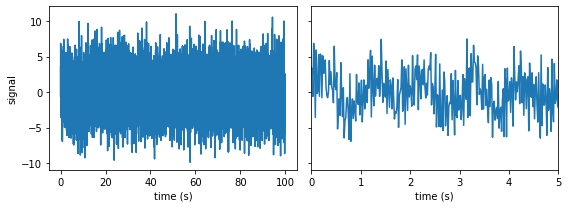

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].plot(t, f_t)
axes[0].set_xlabel("time (s)")
axes[0].set_ylabel("signal")
axes[1].plot(t, f_t)
axes[1].set_xlim(0, 5)
axes[1].set_xlabel("time (s)")
fig.tight_layout()
fig.savefig("ch17-simulated-signal.pdf")
fig.savefig("ch17-simulated-signal.png")
# 왼쪽: 램더 노이즈를 추가한 시뮬레이션된 전체 신호/ 오른쪽: 초기 시간 동안의 확대 그래프

In [9]:
F = fftpack.fft(f_t)

f = fftpack.fftfreq(N, 1/f_s) # # 표본 개수, 연속된 표본 추출 사이의 지속 시간
mask = np.where(f >= 0) # 양의 주파수 성분을 선택하기 위한 마스크 생성

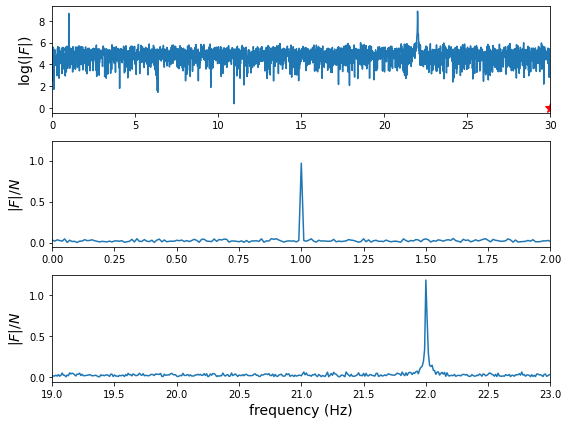

In [10]:
# 1Hz와 22Hz 주파수 성분으로 시뮬레이션 된 신호의 스펙트럼
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].plot(f[mask], np.log(abs(F[mask])), label="real")
axes[0].plot(B, 0, 'r*', markersize=10)
axes[0].set_xlim(0, 30)
axes[0].set_ylabel("$\log(|F|)$", fontsize=14)

axes[1].plot(f[mask], abs(F[mask])/N, label="real")
axes[1].set_xlim(0, 2)
axes[1].set_ylabel("$|F|/N$", fontsize=14)

axes[2].plot(f[mask], abs(F[mask])/N, label="real")
axes[2].set_xlim(19, 23)
axes[2].set_xlabel("frequency (Hz)", fontsize=14)
axes[2].set_ylabel("$|F|/N$", fontsize=14)

fig.tight_layout()
fig.savefig("ch17-simulated-signal-spectrum.pdf")
fig.savefig("ch17-simulated-signal-spectrum.png")

## 주파수 - 영역 필터
- fft 함수: 시간-영역 신호에서 주파수-영역 표현 계산

- ifft 함수: 주파수-영역 표현에서 시간-영역 신호 계산

In [11]:
F_filtered = F * (abs(f) < 2)
f_t_filtered = fftpack.ifft(F_filtered)

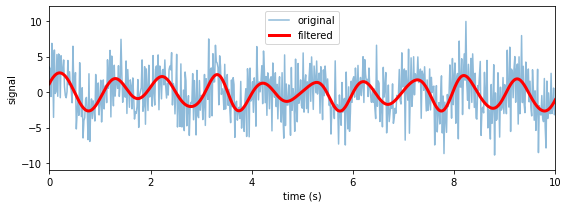

In [12]:
# 원래의 시간-영역 신호와 저주파-통과 필터를 신호의 주파수-영역 표현에 적용해 재구성한 신호
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, f_t, label='original', alpha=0.5)
ax.plot(t, f_t_filtered.real, color="red", lw=3, label='filtered')
ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend()
fig.tight_layout()
fig.savefig("ch17-inverse-fft.pdf")
fig.savefig("ch17-inverse-fft.png")

## 윈도우
- 윈도우 함수를 FFT 적용 전에 적용해 스펙트럼의 품질과 대비를 더욱 개선 가능

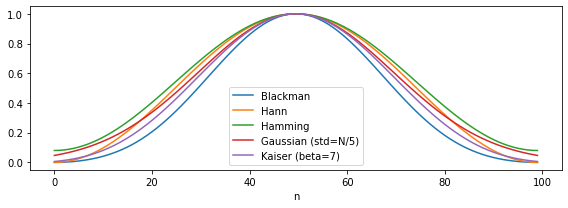

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
N = 100
ax.plot(signal.blackman(N), label="Blackman")
ax.plot(signal.hann(N), label="Hann")
ax.plot(signal.hamming(N), label="Hamming")
ax.plot(signal.gaussian(N, N/5), label="Gaussian (std=N/5)")
ax.plot(signal.kaiser(N, 7), label="Kaiser (beta=7)")
ax.set_xlabel("n")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-window-functions.pdf")

In [14]:
# 데이터셋을 로드한 후 시간 단위 표본으 위해 등간격을 재표본 후 요소를 집계
df = pd.read_csv('temperature_outdoor_2014.tsv', delimiter="\t", names=["time", "temperature"])
df.time = pd.to_datetime(df.time.values, unit="s").tz_localize('UTC').tz_convert('Europe/Stockholm')
df = df.set_index("time")
df = df.resample("1H").ffill()
df = df[(df.index >= "2014-04-01")*(df.index < "2014-06-01")].dropna()

In [15]:
# fftpack 모듈 사용해 시계열 데이터 처리할 수 있도록 numpy배열 추출
time = df.index.astype('int')/1.0e9
temperature = df.temperature.values

# FFT 계산 전 temperature 배열 데이터에 윈도우 함수 적용
window = signal.blackman(len(temperature)) # 스펙트럼 누출 줄이는데 적합

# 시간-영역 신호를 포함한 배열 곱하기
temperature_windowed = temperature * window

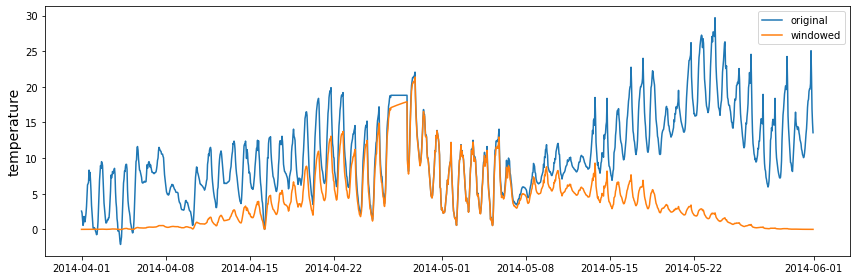

In [16]:
# 원시 및 윈도우된 온도 시계열 신호
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, temperature, label="original")
#ax.plot(df.index, temperature_detrended, label="detrended")
ax.plot(df.index, temperature_windowed, label="windowed")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()

In [17]:
#  스펙트럼 계산
data_fft = fftpack.fft(temperature_windowed)

# 각 주파수 빈에 해당하는 주파수 계산
f = fftpack.fftfreq(len(temperature), time[1]-time[0])

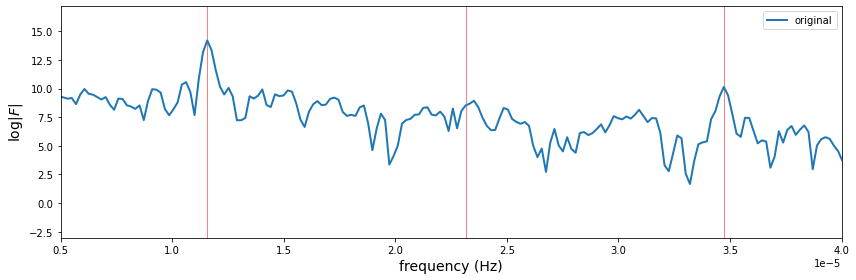

In [19]:
# 윈도우 된 온도 시계열의 스펙트럼

mask = f > 0 # 양의 주파수 선택
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlim(0.000001, 0.000025)
ax.set_xlim(0.000005, 0.00004)

ax.axvline(1./86400, color='r', lw=0.5)
ax.axvline(2./86400, color='r', lw=0.5)
ax.axvline(3./86400, color='r', lw=0.5)
ax.plot(f[mask], np.log(abs(data_fft[mask])**2), lw=2, label="original")
ax.set_ylabel("$\log|F|$", fontsize=14)
ax.set_xlabel("frequency (Hz)", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()

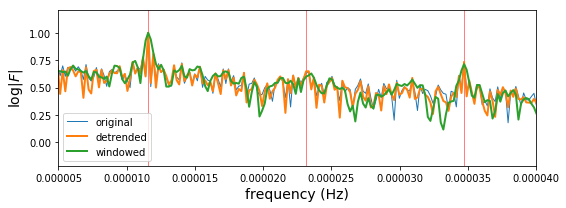

In [45]:
fig, ax = plt.subplots(figsize=(8, 3))
#ax.set_xlim(0.000001, 0.000025)
#ax.set_xlim(0.000005, 0.000018)
ax.set_xlim(0.000005, 0.00004)

ax.axvline(1./86400, color='r', lw=0.5)
ax.axvline(2./86400, color='r', lw=0.5)
ax.axvline(3./86400, color='r', lw=0.5)

y =  np.log(abs(data_fft[mask])**2)
ax.plot(f[mask], y / y[10:].max(), lw=1, label="original")

y = np.log(abs(data_fft_detrended[mask])**2)
ax.plot(f[mask], y / y[10:].max(), lw=2, label="detrended")

y = np.log(abs(data_fft_windowed[mask])**2)
ax.plot(f[mask], y / y[10:].max(), lw=2, label="windowed")

ax.set_ylabel("$\log|F|$", fontsize=14)
ax.set_xlabel("frequency (Hz)", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-spectrum.pdf")

## 스펙트로그램

In [20]:
sample_rate, data = io.wavfile.read("guitar.wav") # 오디오 신호 읽기
sample_rate # 샘플링 속도

44100

In [21]:
data.shape

(1181625, 2)

In [22]:
data = data.mean(axis=1) # 두 채널 평균 형성해 단일 채널 신호 만들기
data.shape[0] / sample_rate # 오디오 녹음의 총 지속 시간 계산

26.79421768707483

In [23]:
# 표본 작은 부분에 대한 스펙트럼 계산하기
N = int(sample_rate/2.0); N # 0.5초 -> 22050표본

# FFt 계산 결과 주파수 빈의 주파수 f와 시간 영역 신호의 표본 샘플링 시간 t 계산
f = fftpack.fftfreq(N, 1.0/sample_rate)
t = np.linspace(0, 0.5, N)
mask = (f > 0) * (f < 1000) # 1000 Hz미만 양의 주파수 선택

subdata = data[:N] # N개 표본 추출
F = fftpack.fft(subdata) # fft 함수 적용

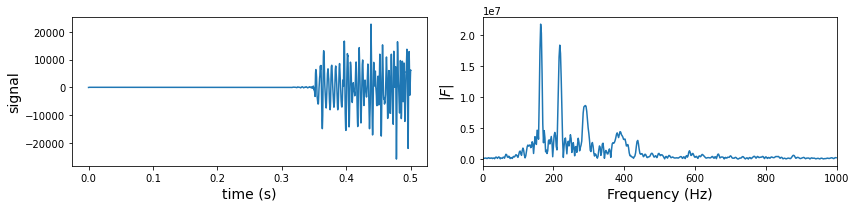

In [24]:
# 기타 소리의 0.5초 표본 신호와 스펙트럼
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(t, subdata)
axes[0].set_ylabel("signal", fontsize=14)
axes[0].set_xlabel("time (s)", fontsize=14)
axes[1].plot(f[mask], abs(F[mask]))
axes[1].set_xlim(0, 1000)
axes[1].set_ylabel("$|F|$", fontsize=14)
axes[1].set_xlabel("Frequency (Hz)", fontsize=14)
fig.tight_layout()
fig.savefig("ch17-guitar-spectrum.pdf")

In [25]:
N_max = int(data.shape[0] / N) # 표본 배열 데이터의 길이 N의 구역 수
# 마스크 계산에 사용할 조건 (양의 주파수 1000Hz 미만)
f_values = np.sum(1 * mask)
spect_data = np.zeros((N_max, f_values))
window = signal.blackman(len(subdata)) # 윈도우 배열

In [26]:
for n in range(0, N_max):
    subdata = data[(N * n):(N * (n + 1))]
    F = fftpack.fft(subdata * window)
    spect_data[n, :] = np.log(abs(F[mask]))

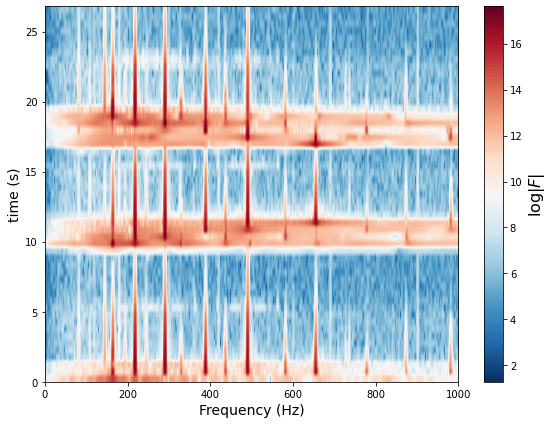

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
p = ax.imshow(spect_data, origin='lower',
              extent=(0, 1000, 0, data.shape[0] / sample_rate),
              aspect='auto',
              cmap=mpl.cm.RdBu_r)
cb = fig.colorbar(p, ax=ax)
cb.set_label("$\log|F|$", fontsize=16)
ax.set_ylabel("time (s)", fontsize=14)
ax.set_xlabel("Frequency (Hz)", fontsize=14)
fig.tight_layout()
fig.savefig("ch17-spectrogram.pdf")
fig.savefig("ch17-spectrogram.png")

# 기타 소리의 오디오 샘플링 스펙트로그램
# 수직 줄무늬: 기타가 만들어내는 음색
# 수평 밴드: 기타 줄이 튕겨지는 시간 주기

## 신호필터
- 신호 처리의 주 목적: 시간 또는 공간 신호를 조작하고 변환하여 그 특성 바꾸기

### 컨볼루션 필터
- 특정 유형의 주파수 필터는 필터의 특성을 나타내는 함수로 신호의 컨볼루션을 이용하여 시간 영역에서 직접 구현할 수 있음

In [28]:
# 컨볼루션을 이용한 대안적 방법
t = np.linspace(0, T, N)
f_t = signal_samples(t)
H = (abs(f) < 2)
h = fftpack.fftshift(fftpack.ifft(H)) # 필터 H의 주파수 응답 함수를 역푸리에 변환
f_t_filtered_conv = signal.convolve(f_t, h, mode='same') # 시간 영역 신호를 컨볼루션

ValueError: x and y must have same first dimension, but have shapes (22050,) and (6000,)

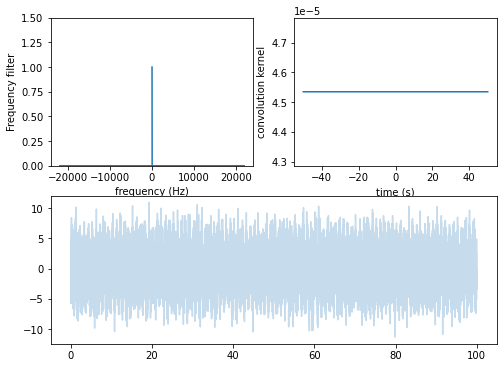

In [29]:
# 주파수 필터와 컨볼루션 필터
fig = plt.figure(figsize=(8, 6))

ax = plt.subplot2grid((2,2), (0,0))
ax.plot(f, H)
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("Frequency filter")
ax.set_ylim(0, 1.5)

ax = plt.subplot2grid((2,2), (0,1))
ax.plot(t - 50, h.real)
ax.set_xlabel("time (s)")
ax.set_ylabel("convolution kernel")

ax = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.plot(t, f_t, label='original', alpha=0.25)
ax.plot(t, f_t_filtered.real, "r", lw=2, label='filtered in frequency domain')
ax.plot(t, f_t_filtered_conv.real, 'b--', lw=2, label='filtered with convolution')
ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend(loc=2)

fig.tight_layout()
fig.savefig("ch17-convolution-filter.pdf")
fig.savefig("ch17-convolution-filter.png")

### FIR 필터
- 유한 임펄스 반응 (FIR) 필터: 전용 디지털 신호 처리기와 범용 처리기로 구현할 수 있는 중요한 특수 경우에 이용

- 무한 임펄스 반응 (IIR) 필터: 새로운 출력값 계산 시 과거 값 추가 포함

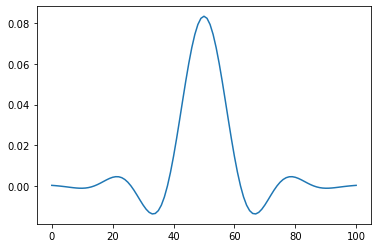

In [30]:
n = 101
f_s = 1.0 / 3600
nyq = f_s/2
# 주어진 밴드 경계의 주파수로 FIR 필터의 bk 계수 계산 가능
b = signal.firwin(n, cutoff=nyq/12, nyq=nyq, window="hamming")
plt.plot(b);

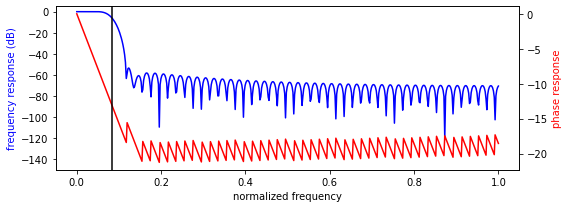

In [31]:
# 저주파 FIR 필터의 진폭과 위상 반응
f, h = signal.freqz(b)
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f/max(f), h_ampl, 'b')
ax.set_ylim(-150, 5)
ax.set_ylabel('frequency response (dB)', color="b")
ax.set_xlabel(r'normalized frequency')
ax = ax.twinx()
ax.plot(f/max(f), h_phase, 'r')
ax.set_ylabel('phase response', color="r")
ax.axvline(1.0/12, color="black")
fig.tight_layout()
fig.savefig("ch17-filter-frequency-response.pdf")

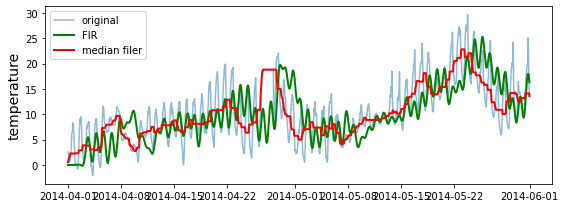

In [32]:
temperature_filtered = signal.lfilter(b, 1, temperature) # IIR 필터 효과
temperature_median_filtered = signal.medfilt(temperature, 25) # 중앙값 필터 적용
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_filtered, color="green", lw=2, label="FIR")
ax.plot(df.index, temperature_median_filtered, color="red", lw=2, label="median filer")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-signal-fir.pdf")

### IIR 필터

In [81]:
b, a = signal.butter(2, 14/365.0, btype='high')


array([ 0.91831745, -1.8366349 ,  0.91831745])

In [82]:
a

array([ 1.        , -1.82995169,  0.8433181 ])

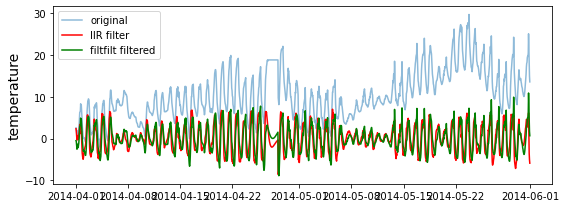

In [33]:
# 저주파는 억제하면서 임계 주파수는 통과시키는 버터워스 고주파 통계 필터 생성 (IIR 필터 설계하기 위해)
b, a = signal.butter(2, 14/365.0, btype='high') 
temperature_filtered_iir = signal.lfilter(b, a, temperature) # 필터 적용
temperature_filtered_filtfilt = signal.filtfilt(b, a, temperature)
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_filtered_iir, color="red", label="IIR filter")
ax.plot(df.index, temperature_filtered_filtfilt, color="green", label="filtfilt filtered")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-signal-iir.pdf")

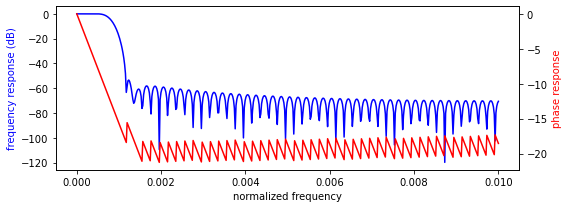

In [34]:
# f, h = signal.freqz(b, a)
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f/max(f)/100, h_ampl, 'b')
ax.set_ylabel('frequency response (dB)', color="b")
ax.set_xlabel(r'normalized frequency')
ax = ax.twinx()
ax.plot(f/max(f)/100, h_phase, 'r')
ax.set_ylabel('phase response', color="r")
fig.tight_layout()

### Filtering Audio

In [88]:
b = np.zeros(5000)
b[0] = b[-1] = 1
b /= b.sum()

In [89]:
data_filt = signal.lfilter(b, 1, data)

In [90]:
io.wavfile.write("guitar-echo.wav",
                 sample_rate,
                 np.vstack([data_filt, data_filt]).T.astype(np.int16))

In [91]:
# based on: http://nbviewer.ipython.org/gist/Carreau/5507501/the%20sound%20of%20hydrogen.ipynb
from IPython.core.display import display
from IPython.core.display import HTML
def wav_player(filepath):
    src = """
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
    </audio>
    """%(filepath)
    display(HTML(src))

In [92]:
wav_player("guitar.wav")

In [93]:
wav_player("guitar-echo.wav")